In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
# BasicSimulator は非推奨になったため、Aer のシミュレータを使用します。
# Aer がインストールされていない場合は、pip install qiskit-aer でインストールしてください。
try:
    from qiskit_aer import AerSimulator
except ImportError:
    print("qiskit-aer が見つかりません。BasicSimulatorを使用します。")
    print("pip install qiskit-aer を実行してインストールすることをお勧めします。")
    # BasicSimulatorは状態ベクトルシミュレーションには非推奨ですが、代替として使えます
    from qiskit.providers.basic_provider import BasicSimulator
    AerSimulator = None  # AerSimulator がないことを示すフラグ

from qiskit.circuit.library import SwapGate
from qiskit.quantum_info import Statevector

# --- 設定 ---
# テストする初期状態のリスト (|abcde> の形式)
initial_states_str = [
    "11001",  # a=1, b=1, c=0, d=0, e=1 -> SWAP -> 11010
    "11010",  # a=1, b=1, c=0, d=1, e=0 -> SWAP -> 11001
    "01001"  # a=0, b=1, c=0 なので条件を満たさない -> 変化なし -> 01001
]

# 量子ビット数
num_qubits = 5

# Qiskitの量子ビットインデックス: q0, q1, q2, q3, q4
# 状態 |abcde> との対応:
# a -> q4
# b -> q3
# c -> q2
# d -> q1
# e -> q0
qubit_map = {'a': 4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}

# 制御ビットのインデックスリスト (a, b, c に対応)
control_qubits = [qubit_map['a'], qubit_map['b'],
                  qubit_map['c']]  # [q4, q3, q2]
# ターゲットビットのインデックスリスト (d, e に対応)
target_qubits = [qubit_map['d'], qubit_map['e']]  # [q1, q0]

# 制御条件: a=1, b=1, c=0
# Qiskitの control メソッドでは、ctrl_state は制御ビットリストの順に対応するビット列を
# *リトルエンディアン* (リストの最後の要素が最上位ビット)で指定します。
# 制御ビットリストが [q4, q3, q2] なので、状態 (a=1, b=1, c=0) は (q4=1, q3=1, q2=0) に対応します。
# ctrl_state は '011' となります (q2=0, q3=1, q4=1)。
control_state_str = '011'  # 制御ビット [q4, q3, q2] が (1, 1, 0) を表す

# 多重制御SWAPゲートを作成
# SwapGate(q1, q0) を q4, q3, q2 で制御する
# SwapGate() は qiskitでは通常、指定された2つの量子ビットを入れ替える
# ここでは target_qubits = [q1, q0] に作用させたい
# SwapGate().control(num_ctrl_qubits, ctrl_state)
# num_ctrl_qubits=3, ctrl_state='011'
controlled_swap_gate = SwapGate(label=f"C3-SWAP({control_state_str})").control(
    num_ctrl_qubits=len(control_qubits),
    ctrl_state=control_state_str
)

print(f"Qiskit 量子ビットインデックス: q0(e), q1(d), q2(c), q3(b), q4(a)")
print(
    f"制御ビット (a,b,c): q{control_qubits[0]}, q{control_qubits[1]}, q{control_qubits[2]}")
print(f"ターゲットビット (d,e): q{target_qubits[0]}, q{target_qubits[1]}")
print(
    f"制御条件 (abc=110): Qiskit ctrl_state='{control_state_str}' (q2,q3,q4 の順)\n")

# --- シミュレーションの実行 ---
simulation_results = {}

for initial_state_str in initial_states_str:
    print(f"--- 初期状態: |{initial_state_str}> ---")

    # 5量子ビットの量子回路を作成
    qc = QuantumCircuit(num_qubits, name=f"Init |{initial_state_str}>")

    # 初期状態 |abcde> を準備する
    # 文字列の左から右へ a, b, c, d, e に対応
    # '1' の場合にXゲートを適用
    for i, bit in enumerate(initial_state_str):
        # 'a'+0 -> 'a', 'a'+1 -> 'b', ...
        qubit_index = qubit_map[chr(ord('a') + i)]
        if bit == '1':
            qc.x(qubit_index)
    qc.barrier()  # 初期化部分と操作部分を視覚的に分離

    # 制御SWAPゲートを適用
    # appendの引数は [制御ビットリスト] + [ターゲットビットリスト]
    # 制御ビット: q4, q3, q2
    # ターゲットビット: q1, q0 (SwapGateはこれらの間で動作)
    qc.append(controlled_swap_gate, control_qubits + target_qubits)

    print("生成された回路:")
    # 'text'出力が見にくい場合は 'mpl' や 'latex_source' を試すこともできます
    try:
        print(qc.draw(output='text', fold=-1))  # fold=-1 で折り返しを防ぐ
    except ImportError:
        print("Circuit drawing requires 'pylatexenc'. Using basic print.")
        print(qc)  # 基本的な文字列表現

    # 状態ベクトルシミュレータで実行
    if AerSimulator:
        simulator = AerSimulator(method='statevector')
    else:
        simulator = BasicSimulator(method='statevector')

    # 回路をシミュレータ用に最適化（必須ではないが推奨）
    compiled_circuit = transpile(qc, simulator)

    # 状態ベクトルを取得
    statevector = Statevector(compiled_circuit)  # これで直接状態ベクトルを取得できる

    # 状態ベクトルから最も確率の高い状態を取得
    # 理想的なシミュレーションなので、1つの状態のみ確率1を持つはず
    probs_dict = statevector.probabilities_dict(decimals=5)  # 確率辞書を取得
    # 最も確率の高い状態のビット列を取得 (Qiskitのリトルエンディアン順 q0q1q2q3q4)
    final_state_qiskit_order = max(probs_dict, key=probs_dict.get)

    # |abcde> (q4q3q2q1q0) の順序に直すために反転
    final_state_abcde_order = final_state_qiskit_order

    simulation_results[initial_state_str] = final_state_abcde_order
    print(f"初期状態: |{initial_state_str}>")
    print(f"最終状態 (Qiskit order q0..q4): |{final_state_qiskit_order}>")
    print(f"最終状態 (abcde order q4..q0): |{final_state_abcde_order}>\n")

# --- 結果の検証 ---
print("\n--- 結果まとめ ---")
for initial, final in simulation_results.items():
    # 期待される最終状態を計算
    a, b, c = [int(bit) for bit in initial[:3]]
    expected_final = initial
    if a == 1 and b == 1 and c == 0:
        # 条件を満たす場合、dとeを入れ替える
        d, e = initial[3], initial[4]
        expected_final = initial[:3] + e + d

    print(f"初期状態: |{initial}>")
    print(f"  期待される最終状態: |{expected_final}>")
    print(f"  シミュレーション結果: |{final}>")
    if final == expected_final:
        print("  \033[92m-> 結果は期待通りです。\033[0m")  # 緑色で表示
    else:
        print("  \033[91m-> 結果が期待と異なります。\033[0m")  # 赤色で表示
    print("-" * 20)

Qiskit 量子ビットインデックス: q0(e), q1(d), q2(c), q3(b), q4(a)
制御ビット (a,b,c): q4, q3, q2
ターゲットビット (d,e): q1, q0
制御条件 (abc=110): Qiskit ctrl_state='011' (q2,q3,q4 の順)

--- 初期状態: |11001> ---
生成された回路:
     ┌───┐ ░    
q_0: ┤ X ├─░──X─
     └───┘ ░  │ 
q_1: ──────░──X─
           ░  │ 
q_2: ──────░──o─
     ┌───┐ ░  │ 
q_3: ┤ X ├─░──■─
     ├───┤ ░  │ 
q_4: ┤ X ├─░──■─
     └───┘ ░    
初期状態: |11001>
最終状態 (Qiskit order q0..q4): |11010>
最終状態 (abcde order q4..q0): |11010>

--- 初期状態: |11010> ---
生成された回路:
           ░    
q_0: ──────░──X─
     ┌───┐ ░  │ 
q_1: ┤ X ├─░──X─
     └───┘ ░  │ 
q_2: ──────░──o─
     ┌───┐ ░  │ 
q_3: ┤ X ├─░──■─
     ├───┤ ░  │ 
q_4: ┤ X ├─░──■─
     └───┘ ░    
初期状態: |11010>
最終状態 (Qiskit order q0..q4): |11001>
最終状態 (abcde order q4..q0): |11001>

--- 初期状態: |01001> ---
生成された回路:
     ┌───┐ ░    
q_0: ┤ X ├─░──X─
     └───┘ ░  │ 
q_1: ──────░──X─
           ░  │ 
q_2: ──────░──o─
     ┌───┐ ░  │ 
q_3: ┤ X ├─░──■─
     └───┘ ░  │ 
q_4: ──────░──■─
           ░    
初期状態: |01001>
最終

In [ ]:
from qiskit import __version__
from qiskit.quantum_info import Statevector, Operator
from numpy import sqrt

zero = Statevector.from_label("0")
one = Statevector.from_label("1")
psi = zero.tensor(one)
display(psi.draw("latex"))

plus = Statevector.from_label("+")
minus_i = Statevector.from_label("l")
phi = plus.tensor(minus_i)
display(phi.draw("latex"))

H = Operator.from_label("H")
I = Operator.from_label("I")
X = Operator.from_label("X")
display(H.tensor(I).draw("latex"))

display((H ^ I ^ X).draw("latex"))

display(phi.evolve(H ^ I).draw("latex"))

CX = Operator(
    [[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 0, 1],
     [0, 0, 1, 0]])  # type: ignore
psi = plus.tensor(zero)
display(psi.evolve(CX).draw("latex"))

w = Statevector([0, 1, 1, 0, 1, 0, 0, 0] / sqrt(3))
display(w.draw("latex"))

result, state = w.measure([0])
print(f"Measured: {result}\nState after measurement:")
display(state.draw("latex"))

result, state = w.measure([0, 1])
print(f"Measured: {result}\nState after measurement:")
display(state.draw("latex"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Measured: 1
State after measurement:


<IPython.core.display.Latex object>

Measured: 10
State after measurement:


<IPython.core.display.Latex object>

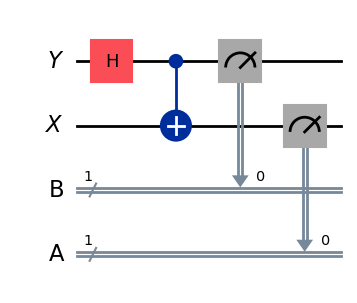

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

X = QuantumRegister(1, "X")
Y = QuantumRegister(1, "Y")
A = ClassicalRegister(1, "A")
B = ClassicalRegister(1, "B")

circuit = QuantumCircuit(Y, X, B, A)
circuit.h(Y)
circuit.cx(Y, X)
circuit.measure(Y, B)
circuit.measure(X, A)

display(circuit.draw(output="mpl"))

はい、承知いたしました。画像に示されている下の計算結果を実際に確かめてみましょう。

画像の下の式は次のようになっています。
$$\langle \psi_{\alpha} \otimes \psi_{\beta} | \phi^{+} \rangle = \frac{\cos(\alpha)\cos(\beta) + \sin(\alpha)\sin(\beta)}{\sqrt{2}}$$

ここで、標準的な量子ビットの状態とベル状態の定義を用いると考えられます。

1.  **状態の定義:**
    * おそらく、単一量子ビットの状態は $|\psi_{\alpha}\rangle = \cos(\alpha)|0\rangle + \sin(\alpha)|1\rangle$ と定義されているでしょう。同様に $|\psi_{\beta}\rangle = \cos(\beta)|0\rangle + \sin(\beta)|1\rangle$ です。
    * $|\phi^{+}\rangle$ は、4つのベル状態のうちの1つで、通常 $|\phi^{+}\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$ と定義されます。

2.  **テンソル積 $|\psi_{\alpha} \otimes \psi_{\beta}\rangle$ の計算:**
    まず、2つの状態のテンソル積（合成状態）を計算します。
    $$
    \begin{aligned} |\psi_{\alpha} \otimes \psi_{\beta}\rangle &= |\psi_{\alpha}\rangle \otimes |\psi_{\beta}\rangle \\ &= (\cos(\alpha)|0\rangle + \sin(\alpha)|1\rangle) \otimes (\cos(\beta)|0\rangle + \sin(\beta)|1\rangle) \\ &= \cos(\alpha)\cos(\beta)|0\rangle \otimes |0\rangle + \cos(\alpha)\sin(\beta)|0\rangle \otimes |1\rangle \\ &\quad + \sin(\alpha)\cos(\beta)|1\rangle \otimes |0\rangle + \sin(\alpha)\sin(\beta)|1\rangle \otimes |1\rangle \\ &= \cos(\alpha)\cos(\beta)|00\rangle + \cos(\alpha)\sin(\beta)|01\rangle \\ &\quad + \sin(\alpha)\cos(\beta)|10\rangle + \sin(\alpha)\sin(\beta)|11\rangle \end{aligned}
    $$

3.  **ブラベクトル $\langle \psi_{\alpha} \otimes \psi_{\beta} |$ の計算:**
    ケットベクトル $|\psi_{\alpha} \otimes \psi_{\beta}\rangle$ に対応するブラベクトルは、係数の複素共役を取り、ケットをブラに置き換えることで得られます。（ここでは係数は実数と仮定します）
    $$
    \begin{aligned} \langle \psi_{\alpha} \otimes \psi_{\beta} | &= (\cos(\alpha)\cos(\beta)|00\rangle + \cos(\alpha)\sin(\beta)|01\rangle \\ &\quad + \sin(\alpha)\cos(\beta)|10\rangle + \sin(\alpha)\sin(\beta)|11\rangle)^{\dagger} \\ &= \cos(\alpha)\cos(\beta)\langle 00| + \cos(\alpha)\sin(\beta)\langle 01| \\ &\quad + \sin(\alpha)\cos(\beta)\langle 10| + \sin(\alpha)\sin(\beta)\langle 11| \end{aligned}
    $$

4.  **内積 $\langle \psi_{\alpha} \otimes \psi_{\beta} | \phi^{+} \rangle$ の計算:**
    いよいよ内積を計算します。正規直交基底 $|00\rangle, |01\rangle, |10\rangle, |11\rangle$ の性質 $\langle ij | kl \rangle = \delta_{ik}\delta_{jl}$ （$i=k$ かつ $j=l$ のとき1、それ以外は0）を使います。
    $$
    \begin{aligned} \langle \psi_{\alpha} \otimes \psi_{\beta} | \phi^{+} \rangle &= \left( \cos(\alpha)\cos(\beta)\langle 00| + \cos(\alpha)\sin(\beta)\langle 01| + \sin(\alpha)\cos(\beta)\langle 10| + \sin(\alpha)\sin(\beta)\langle 11| \right) \left( \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) \right) \\ &= \frac{1}{\sqrt{2}} \left[ \cos(\alpha)\cos(\beta)\langle 00|(|00\rangle + |11\rangle) + \cos(\alpha)\sin(\beta)\langle 01|(|00\rangle + |11\rangle) \right. \\ &\qquad \left. + \sin(\alpha)\cos(\beta)\langle 10|(|00\rangle + |11\rangle) + \sin(\alpha)\sin(\beta)\langle 11|(|00\rangle + |11\rangle) \right] \\ &= \frac{1}{\sqrt{2}} \left[ \cos(\alpha)\cos(\beta)(\langle 00|00\rangle + \langle 00|11\rangle) + \cos(\alpha)\sin(\beta)(\langle 01|00\rangle + \langle 01|11\rangle) \right. \\ &\qquad \left. + \sin(\alpha)\cos(\beta)(\langle 10|00\rangle + \langle 10|11\rangle) + \sin(\alpha)\sin(\beta)(\langle 11|00\rangle + \langle 11|11\rangle) \right] \\ &= \frac{1}{\sqrt{2}} \left[ \cos(\alpha)\cos(\beta)(1 + 0) + \cos(\alpha)\sin(\beta)(0 + 0) + \sin(\alpha)\cos(\beta)(0 + 0) + \sin(\alpha)\sin(\beta)(0 + 1) \right] \\ &= \frac{1}{\sqrt{2}} [ \cos(\alpha)\cos(\beta) + \sin(\alpha)\sin(\beta) ] \\ &= \frac{\cos(\alpha)\cos(\beta) + \sin(\alpha)\sin(\beta)}{\sqrt{2}} \end{aligned}
    $$

以上の計算により、画像に示された下の式
$$\langle \psi_{\alpha} \otimes \psi_{\beta} | \phi^{+} \rangle = \frac{\cos(\alpha)\cos(\beta) + \sin(\alpha)\sin(\beta)}{\sqrt{2}}$$
が成り立つことが確かめられました。

また、最初の式 $\langle\psi_{\alpha}|\psi_{\beta}\rangle = \cos(\alpha - \beta)$ を使うと、この結果は
$$\langle \psi_{\alpha} \otimes \psi_{\beta} | \phi^{+} \rangle = \frac{\cos(\alpha - \beta)}{\sqrt{2}}$$
と書くこともできますね。